## Introduction (15%)


SARS-CoV-2is a novel virus form of coronavirus that is at the center of a global pandemic. Tracking cases of COVID-19 has revealed multiple strains and forms of the disease that have slowly evolved since the initial tracking began in December 2019 (Pachetti et. al. 2020). The ability to understand and monitor such mutations is vital toward developing solutions for targeted therapies and provides a genetic paper trail by which cases can be traced. Unfortunately, modern genetic sequencing techniques are unable to read DNA sequences in their entirety, so they must be blasted into thousands of small fragments (called 'kmers') that are then reassembled after sequencing.  </br></br>
The first method of sequencing DNA, known as Sanger or Sanger Singer sequencing, originated in 1975 when two-time Nobel Laureate Frederick Sanger published the landmark article detailing methods for determining sequences of DNA by replicating the same machinery used within our bodies externally (Sanger et. al. 1975). This paper served as a revolution for the field, and the methods detailed are still used today for small scale operations; however, the high time intensity has made it infeasible for large scale genetic sequencing. Thus, high throughput next generation sequencing methods were developed to sequence multiple small fragments in parallel. Both Sanger and next-gen sequencing produce kmers that must be reassembled to create meaningful results, providing the basis of the sequence assembly problem tackled here.   </br></br>
At its core, sequence assembly is a highly computationally complex operation that can be formulated as a traveling salesman problem (TSP): we aim to use each kmer exactly once, and ultimately generate a path through the kmers to end with a final assembled sequence. Sequence assembly, and more broadly TSP, fall into the realm of dynamic programming problems, where simpler subproblems are solved to generate the final optimal solution. Multiple factors can affect the success of assembly, including the length of each kmer, k: the process of finding the optimal length for k remains an open problem despite having multiple proposed solutions. First, we formulate our TSP mathematical model in Julia as an optimization problem using the Gurobi solver. For testing the time efficiency and accuracy of our model, we begin with a simpler case using a short (~100 bp) partial coding sequence of the SARS-CoV-2 surface glycoprotein gene obtained from NCBI (accession no. MN938389.1) and then demonstrate validation through the use of approximately ~850 publicly avaialable kmers of length k = 25 unique to SARS-COV-2 (https://genexa.ch/sars2-bioinformatics-resources/) that are assembled into a reference sequence, and then resplit for additional testing. Finally, to explore the importance of kmer length, we split our ground truth sequences into multiple kmer testing sets of length 4 through 75 that are assembled using the same method and compared with the reference sequence for both speed and accuracy. All datasets used will be provided with the final submission.


## Mathematical Model (25%)



This is a MIP, specifically the traveling salesman problem. The decision variables $x_{ij}$ are binary and indicate which kmer j comes after kmer i. The variables $u_i$ are Miller-Tucker-Zemlin variables to prevent subtours from forming. The values $c_{ij}$ are the cost of kmer j following kmer i and correspond with the number of overlapping nucleotides between the end of kmer i and the beginning of kmer j, with the exception that the cost is 0 when i=j (the kmer cannot be followed by itself). The number of overlapping nucleotides is multiplied by -1, so that cost is minimized by visiting the node of the kmer with the largest number of overlapping nucleotides.  
  
The standard form of this problem is given below, where n is the number of kmers the nucleotide sequence is broken into (will depend on chosen value of k).  

$$ \text{min}_{x,u} \sum_i \sum_j c_{ij} x_{ij} $$
$$ \; \; \; \; \; \; \text{s.t.} \sum_i x_{ij} = 1 \; \forall \; j $$
$$ \; \; \; \; \; \; \; \; \; \sum_j x_{ij} = 1 \; \forall \; i $$
$$ \; \; \; \; \; \; \; \; \; \; \; x_{ij} \in \{0,1\} \; \forall \; i,j $$
$$ \; \; \; \; \; \; \; \; \; \; 1 \leq u_i \leq n \; \forall \; i $$
$$ \; \; \; \; \; \; u_i - u_j +nx_{ij} \leq n-1 \; \forall \; i,j, j\neq 1$$

## Solution (25%)

### Ensure Julia is properly set up

Here, we need to connect to a local host runtime within the jupyter environment. Additional steps are taken to ensure that we 'trust' the google colab environment. 

In [ ]:
versioninfo()

Julia Version 1.3.1
Commit 2d5741174c (2019-12-30 21:36 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: AMD Ryzen 9 4900HS with Radeon Graphics         
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, znver1)


In [ ]:
using Pkg; Pkg.add("BenchmarkTools"); 
using BenchmarkTools

M = rand(2048, 2048)
@benchmark M^2

  Updating registry at `C:\Users\Peter Rehani\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `C:\Users\Peter Rehani\.julia\environments\v1.3\Project.toml`
 [no changes]
  Updating `C:\Users\Peter Rehani\.julia\environments\v1.3\Manifest.toml`
 [no changes]


BenchmarkTools.Trial: 
  memory estimate:  32.00 MiB
  allocs estimate:  2
  --------------
  minimum time:     184.865 ms (0.20% GC)
  median time:      234.412 ms (0.00% GC)
  mean time:        245.779 ms (3.71% GC)
  maximum time:     335.503 ms (2.16% GC)
  --------------
  samples:          21
  evals/sample:     1

In [ ]:
# Load necessary packages
Pkg.add("FastaIO"); Pkg.add("JuMP"); Pkg.build("Gurobi"); Pkg.add("Gurobi")
using FastaIO, JuMP, Gurobi 

 Resolving package versions...
  Updating `C:\Users\Peter Rehani\.julia\environments\v1.3\Project.toml`
 [no changes]
  Updating `C:\Users\Peter Rehani\.julia\environments\v1.3\Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `C:\Users\Peter Rehani\.julia\environments\v1.3\Project.toml`
 [no changes]
  Updating `C:\Users\Peter Rehani\.julia\environments\v1.3\Manifest.toml`
 [no changes]
  Building Gurobi → `C:\Users\Peter Rehani\.julia\packages\Gurobi\7YNJV\deps\build.log`
 Resolving package versions...
  Updating `C:\Users\Peter Rehani\.julia\environments\v1.3\Project.toml`
 [no changes]
  Updating `C:\Users\Peter Rehani\.julia\environments\v1.3\Manifest.toml`
 [no changes]


┌ Info: Precompiling Gurobi [2e9cd046-0924-5485-92f1-d5272153d98b]
└ @ Base loading.jl:1273


### Functions for going from kmer generation to sequence assembly
Since we are trying to simulate the output from sequencing, we need to break our sequence into kmers that we will then try to assemble using our model. 

In [ ]:
using Distributed
addprocs(16)

### Step 1: Kmer Generation ###
# Split the sequence into kmers of length k
function split_sequence(seq, k)
    kmer_array = []
    for i in 1:length(seq)
        if i <= (length(seq) - (k-1))
            push!(kmer_array, seq[i:i+k-1])
        end
    end
    print(typeof(kmer_array))
    return kmer_array
end

Now that we have the kmers, we create the cost matrix. The cost matrix is nxn, where n is the number of kmers produced from the previous step, and the (ij) entry represents the number of overlappying nucleotides between the end of kmer i and the beginning of kmer j.

In [ ]:
### Step 2: Generate cost matrix ###
# Calculates the number of overlapping characters between the end of kmer_1 and the beginning of kmer_2
function get_overlap(kmer_1, kmer_2)
    k = length(kmer_1) # all the kmers are the same length, so we can get k by taking the length of kmer_1
    overlap = 0
    i = k
    while i > 0 # While we are still within the length of the kmer
        if kmer_1[k-(i-1):k] == kmer_2[1:i] # start by checking for maximum number of overlapping nucleotides
            overlap = i
            break
        end
        i -= 1 # if no overlap found, decrease range
    end
    return overlap
end


# Returns the cost matrix for a given kmer array
function get_cost_matrix(kmer_array)
    cost_mat = zeros(length(kmer_array), length(kmer_array)) # initialize empty matrix
    for i in 1:length(kmer_array)
        for j in 1:length(kmer_array)
            # leave cost as 0 if there is no overlap (0 is the max possible cost)
            if i != j
                # Multiply number overlapping nucleotides by -1 so that more overlap has smaller cost
                cost_mat[i,j] = -1*get_overlap(kmer_array[i], kmer_array[j]) 
            end
        end
    end
    return cost_mat
end


Now that we have the scoring matrix, we have all the necessary components to solve the TSP problem. 

In [ ]:
### Step 3: Solve TSP using Miller-Tucker-Zemlin formulation
# Solve kmer assembly as TSP
function solve_as_TSP(cost_mat)
    N = size(cost_mat, 1)
    m = Model(Gurobi.Optimizer)
    set_optimizer_attribute(m, "OutputFlag", 0)
    
    @variable(m, x[1:N, 1:N], Bin) # Binary variables indicating which kmer node to visit next
    @variable(m, u[1:N]) # MTZ variables
    
    @constraint(m, c1[j in 1:N], sum(x[i,j] for i in 1:N) == 1) # exactly one edge out of each node
    @constraint(m, c2[i in 1:N], sum(x[i,j] for j in 1:N) == 1) # exactly one edge into each node
    @constraint(m, c3[i in 1:N, j in 2:N], u[i] - u[j] + N*x[i,j] <= N-1) # MTZ constraint
    
    @objective(m, Min, sum(x[i,j]*cost_mat[i,j] for i in 1:N, j in 1:N)) # minimize cost
    
    optimize!(m)
    
    xx = value.(x)
    sol = zeros(N, N)
    for i in 1:N
        for j in 1:N
            sol[i,j] = Int(xx[i,j])
        end
    end
    
    return sol
end

The solution to the TSP problem is a matrix of 1s and 0s indicating the order in which kmers are visited. The next step is to convert this back into a sequence of nucleotides, where we "collapse" the overlapping nucleotides between kmers.

In [ ]:
### Step 4: Assemble sequence from kmers ###
# Returns the cycle containing the start node from output of IP
function getCycle(x)
    N = size(x, 1)
    start = 1
    cycle = [start]
    while true
        j = cycle[end]
        for k in 1:N
            if x[k,j] == 1
                push!(cycle, k)
                break
            end
        end
        if cycle[end] == start
            break
        end
    end
    return cycle[2:end] # break loop
end

# Returns array of kmers from array of kmer indices
function getKmers(cycle, kmer_array)
    kmers = []
    for i in 1:length(cycle)
        push!(kmers, kmer_array[cycle[i]])
    end
    return kmers
end


# Takes array of kmers and returns sequence
function assembleKmers(kmers)
    k = length(kmers[1])
    seq = kmers[1]
    for i in 1:length(kmers)-1
        overlap = get_overlap(kmers[i], kmers[i+1])
        if overlap > 0
            # "collapse" overlapping nucleotides
            seq = string(seq, kmers[i+1][overlap+1:k])
        else
            # if no overlapping nucleotides, add kmer to the end
            seq = string(seq, kmers[i+1])
        end
    end
    return seq
end
;

Lastly, since we want to repeat this whole process several times, we create a function to run through all of these steps. The input is either an array of kmers or a nucleotide sequence which will be broken down into kmers to simulate the output from sequencing. The output is the assembled sequence.

In [ ]:
# Runs through all steps, starting by splitting the sequence into kmers and ending with a re-assembled sequence
function seq_assembly_as_TSP(seq, k, split_kmers)
    if split_kmers
      kmer_array = split_sequence(seq, k)
    else
      kmer_array = seq
    end
    cost_mat = get_cost_matrix(kmer_array)
    sol_k = solve_as_TSP(cost_mat)
    cycle_k = getCycle(sol_k)
    kmers = getKmers(cycle_k, kmer_array)
    seq_k = assembleKmers(reverse(kmers))
    
    return seq_k
end
; 

### Load Sequences
Now we are ready to load our sequences and run through the assembly steps.

In [ ]:
# Read fasta file to get description and sequence for shorter read (SARS-CoV-2 surface glycoprotein gene)
fr = FastaReader("S_gene_MN938389.fasta")
name, seq = readentry(fr);

# Read fasta file for 850 kmer stress test
seqs_25 = [] 
for (name_i, seq_i) in FastaReader("unique_sars2.k25.fasta")
    push!(seqs_25, seq_i)
end 

### For loop to get the assembled sequences for different values of k

In [ ]:
results = []
for k in 4:75
    curr_assembly = @timed seq_assembly_as_TSP(seq, k, true) 
    push!(results, curr_assembly)
end
assembled_seqs = [x[1] for x in results]
timings = [x[2] for x in results]

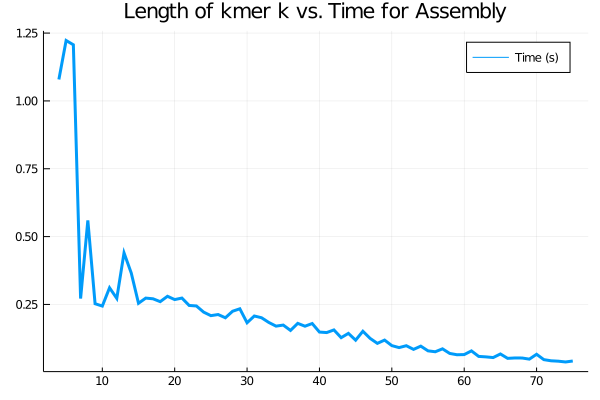

In [ ]:
using Plots
x = 4:75
plot(x, timings,  title = "Length of kmer k vs. Time for Assembly", label = "Time (s)", lw = 3, fmt = :png)

In [ ]:
error_array = [] 
for sequence in assembled_seqs
    temp_counter = 0 
    for i in 1:min(length(seq), length(sequence))
        if seq[i] != sequence[i]
            temp_counter += 1
        end
    end 
    if length(seq) > length(sequence)
        temp_counter += (length(seq) - length(sequence))
    end 
    push!(error_array, temp_counter)
end

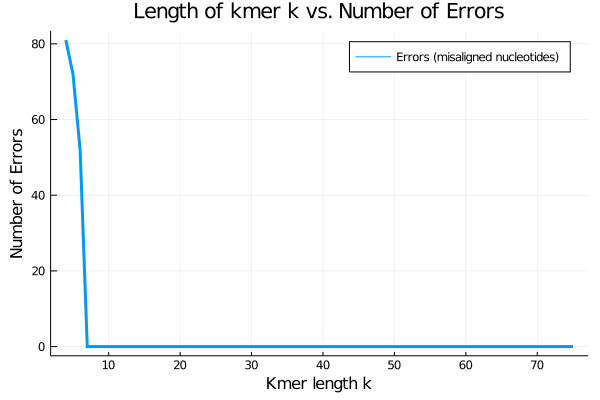

In [ ]:
using Plots
x = 4:75
plot(x, error_array,  title = "Length of kmer k vs. Number of Errors", label = "Errors (misaligned nucleotides)", xlabel = "Kmer length k", ylabel = "Number of Errors", lw = 3, fmt = :png)

In [ ]:
ref_seq_25 = seq_assembly_as_TSP(seqs_25, 25, false)

Academic license - for non-commercial use only
Academic license - for non-commercial use only


"AAAACCTTCAACACCATTACAAGGTGTGCTAATTCTTTCACACGTGGTGTTTATTATAACCCTGTCCTACCATTTAATGATATTAACCTTGACCAGGGCTTTAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGTTAAAGCCCTGGTCAAGGTTAATATAGGCGGATTGACTAGCTACACTACGTGCCCGCCGAGGAGAATTAGTCTGAGTCTGACTAAAACTATTCACTTCAATAGTCTCAAAAGGTTTGAGATTAGACTTCCTAAACAATCTATACAGGTAATTATAATTACCACCAACCTTAGAATCAAGATTGTTAGAATTCCAACCTCAACAATTGTTTGAATAGTAGCACACCTTGTAATGGTGTTGAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTAATGGTGTTGGTTACCATTAAATGGTAGGACAGGGTTATCACTACTATTCAAACAATTGTTGAGGTTCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAACACTTAAAAGTGGAAAATGATGCGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAAGCTGCGCTGTGCACCTTTTTGTTATTGTCCTCACTGCCGTCTTGTTGACCAACAAAAAGGTGCACAGCGCAGCTTCGTAATAAACACCACGTGTGAAAGAATTAGTGTAACCAACACCATTAGTGGGTTGGAAACCATATGATTGTAAAGGAAAGTAACAATTAAAACCTTCAACACCATTACAA"

In [ ]:
assembled_seqs_25 = []
push!(assembled_seqs_25, ref_seq_25)
results_25 = []
Threads.@threads for k in 15:75
    curr_assembly = @timed seq_assembly_as_TSP(ref_seq_25, k, true)
    push!(results_25, curr_assembly)
    print(curr_assembly)
end
assembled_seqs_25 = [x[1] for x in results_25]
timings_25 = [x[2] for x in results_25]

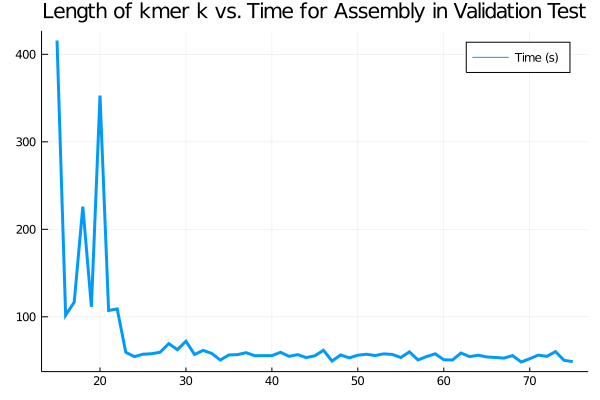

In [38]:
using Plots
x = 15:75 
plot(x, timings_25,  title = "Length of kmer k vs. Time for Assembly in Validation Test", label = "Time (s)", lw = 3, fmt = :png)

In [ ]:
error_array_25 = [] 
for sequence in assembled_seqs_25 
    temp_counter = 0 
    for i in 1:min(length(ref_seq_25), length(sequence))
        if ref_seq_25[i] != sequence[i]
            temp_counter += 1
        end
    end 
    if length(ref_seq_25) > length(sequence)
        temp_counter += (length(ref_seq_25) - length(sequence))
    end 
    push!(error_array_25, temp_counter)
end

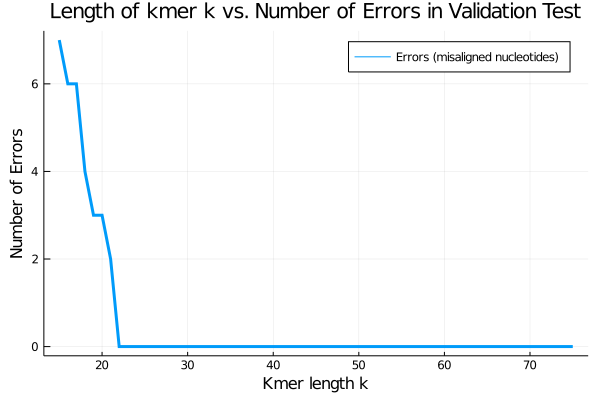

In [39]:
using Plots
x = 15:75
plot(x, error_array_25,  title = "Length of kmer k vs. Number of Errors in Validation Test", label = "Errors (misaligned nucleotides)", xlabel = "Kmer length k", ylabel = "Number of Errors", lw = 3, fmt = :png)

## Results and Discussion (25%)

The results of the sequence assembly method demonstrate great performance for the initial short reads (approx. 100 bases); however, for longer stress tests (approx. 850 bases), the computational complexity drastically increases as one would expect with the problem formulation. We began by first testing our simple sequence alignment for values of $k=4:50$ to test the performance of the model. With higher values of k, it becomes apparent that the model drastically sped up. We quantify this by tracking and plotting the run time for various values of $k$. Additionally, we checked accuracy against the known reference sequence and found $k=5,6,7$ produced incorrect results ranging from a single nucleotide base to completetly different final results. This was likely due to the fact that, for $k=5$, we are less likely to have unique kmers which increases the probability of spurious overlaps and drastically reduces the efficiency of the model.  


![Basic testing](https://i.imgur.com/BJfJrqj.png)
![Error testing](https://i.imgur.com/Na6p7dT.png)  
For the larger sequence, we see significant time increases for lower values of k. Further, as we compose a reference sequence and then aim to reassemble it, the increased length drastically increases compute times as well. As such, the minimum viable length we could reassemble was $k=15$ through $k=75$ on our hardware and timeframe. The error rate slowly smoothens out for larger values of $k$, until it reached the critical value and no further errors occurred. 

![Stress testing](https://i.imgur.com/UHBX0mD.png)
![Stress testing error](https://i.imgur.com/N5drcQs.png)  

Taken together, these results demonstrate the importance of defining a good value for $k$. There is an obvious tradeoff between kmer length and total run time for smaller values of $k$; however, one drawback that was not depicted in the data presented is the fact that larger $k$'s are more sensitive to errors in the sequencing process. Thus, a balancing act between efficiency and sensitivity must be put into place to accurately assign a fitting kmer length. An overarching drawback throughout the entire process of analysis came from the high computational demand required to run and develop the data presented. Attempts were made to mitigate this by setting a custom threads environment variable for Julia. Despite the fact that additional computational horsepower would likely solve many of these limitations on a smaller scale, highly specific and complex algorithms designed for general sequence assembly will vastly outperform non-specific methods such as the one presented here. In particular, we attempt to solve the problem from scratch rather than using a previously solved subproblem. In the case of general sequencing, the known sequenced genome is used as a starting point to simplify many of the calculations. Optimally, additional compute resources can work in tandem with better adapted algorithms to greatly improve overall run time. 

## Conclusions (5%)

One particularly interesting future direction would be to integrate the base genome of SARS-CoV-2 (i.e. areas that are known not to change from mutation site to mutation site) and see if that potentially impacts performance. This would further feed into the general fundamental principles of dynamic progrmming by using an already solved, optimal subproblem and building upon it for each of the individual mutant strains. Additionally, the general methods here can be used to track amino acid (components encoded by DNA) changes to see if any missense mutations, or mutations that fundamentally disrupt the function of a given DNA sequence, occur. While this is unlikely in a real world application as there is little chance of such a mmutation spreading successfully, it still provides an interesting exercise in terms of building upon this work to help the global understanding of COVID-19. All in all, while the method implemented and analyzed here will not make headlines as a groundbreaking new approach, it fundamentally displays a key problem in modern bioinformatics and applies it to a highly relelvant subject mattter. 

## Works Cited 
Pachetti, M., Marini, B., Benedetti, F., Giudici, F., Mauro, E., Storici, P., . . . Ippodrino, R. (2020). Emerging SARS-CoV-2 mutation hot spots include a novel RNA-dependent-RNA polymerase variant. Journal of Translational Medicine, 18(1). doi:10.1186/s12967-020-02344-6 </br> 

Sanger, F., & Coulson, A. (1975). A rapid method for determining sequences in DNA by primed synthesis with DNA polymerase. Journal of Molecular Biology, 94(3), 441-448. doi:10.1016/0022-2836(75)90213-2

Nucleotide [Internet]. Bethesda (MD): National Library of Medicine (US), National Center for Biotechnology Information; [1988] - [cited 2020 July 30]. Accession No. MN938389.1, Severe acute respiratory syndrome coronavirus 2 isolate 2019-nCoV_HKU-SZ-004_2020 surface glycoprotein (S) gene, partial cds. Available from: https://www.ncbi.nlm.nih.gov/nuccore/MN938389


Schmid, M. (n.d.). SARS-CoV-2 bioinformatics resources. Retrieved August 01, 2020, from https://genexa.ch/sars2-bioinformatics-resources/